# AI for Science Training - Week 02

### Damyn Chipman - Boise State University

## Intro to AI on Supercomputers

## Homework: Train a Nonlinear Classifier

1. Write some code to train the NonlinearClassifier.
2. Create a data loader for the test data and check your model's accuracy on the test data. 

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

---

## Homework Submission

The goal of this exercise is to design and train a nonlinear neural network to classify the MNIST dataset. We will create a dense neural network with a number of hidden nodes as our classifier.

### Module Imports

In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

import IPython.display as ipydis

### Training, Validation, and Test Data

In [2]:
# Training data
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Test data
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Validation data (split from training)
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

# Batch size
batch_size = 128

# Create dataloader (make the datasets iterable)
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


In [3]:
if torch.cuda.is_available():
    dev = torch.device("cuda")
else:
    dev = torch.device("cpu")

def preprocess(x, y):
    return x.to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        self.dataset = dl.dataset

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)
test_dataloader = WrappedDataLoader(test_dataloader, preprocess)

### The NonLinear Classifier

This network is a dense network with 2 hidden layers.

In [4]:
class MyNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

### Training and Evaluation

In [5]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()
        
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

Epoch 0: training loss: 0.26269025113185246, accuracy: 92.14375
Validation loss: 0.2681, validation accuracy: 91.83%


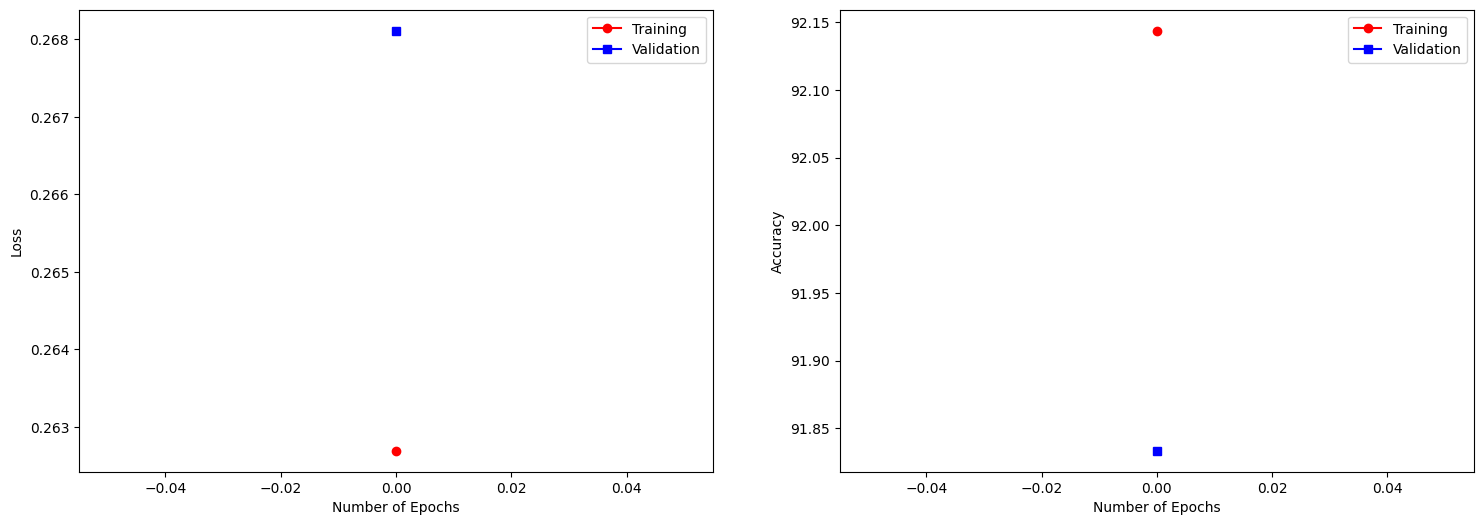

Epoch 1: training loss: 0.2358766713142395, accuracy: 92.8875
Epoch 2: training loss: 0.21167993702491125, accuracy: 94.00833333333334
Epoch 3: training loss: 0.1817726587454478, accuracy: 94.72291666666666
Epoch 4: training loss: 0.17886140152812005, accuracy: 94.84166666666667
Validation loss: 0.2022, validation accuracy: 94.23%


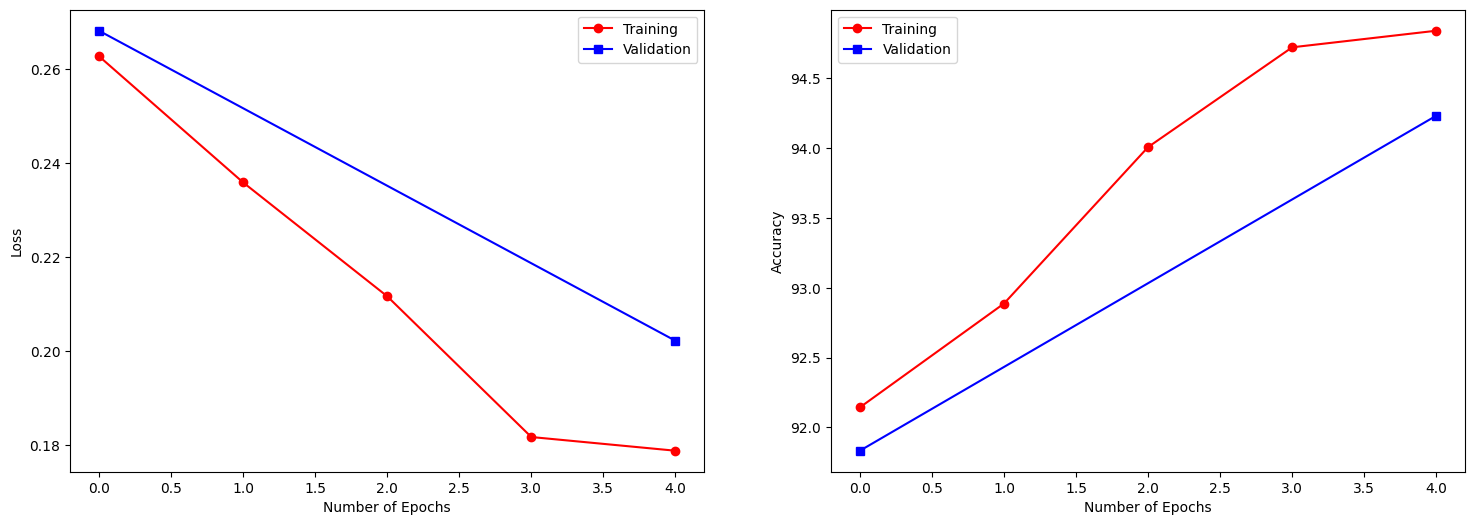

Epoch 5: training loss: 0.19275978139042854, accuracy: 94.53333333333333
Epoch 6: training loss: 0.16950141037503877, accuracy: 95.15625
Epoch 7: training loss: 0.1753383519053459, accuracy: 94.96875
Epoch 8: training loss: 0.1638805233935515, accuracy: 95.23125
Validation loss: 0.1957, validation accuracy: 94.42%


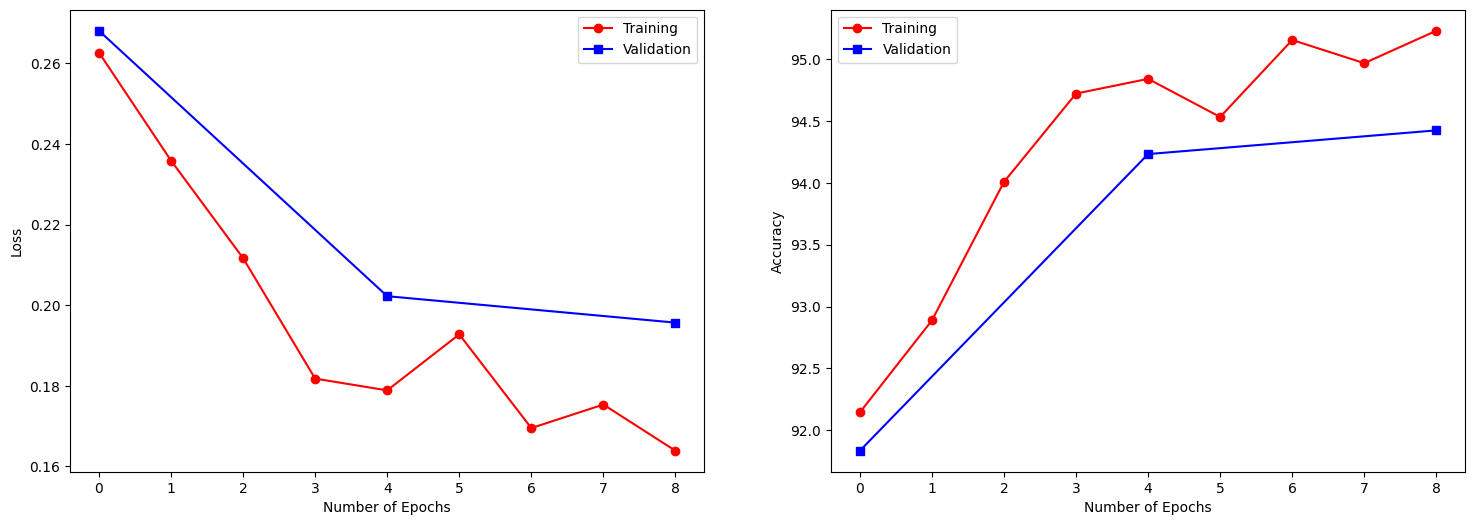

Epoch 9: training loss: 0.16135950754086176, accuracy: 95.32708333333333
Epoch 10: training loss: 0.1645019517938296, accuracy: 95.175
Epoch 11: training loss: 0.16014328204592068, accuracy: 95.42291666666667
Epoch 12: training loss: 0.16700928775469462, accuracy: 94.95625
Validation loss: 0.2018, validation accuracy: 94.19%


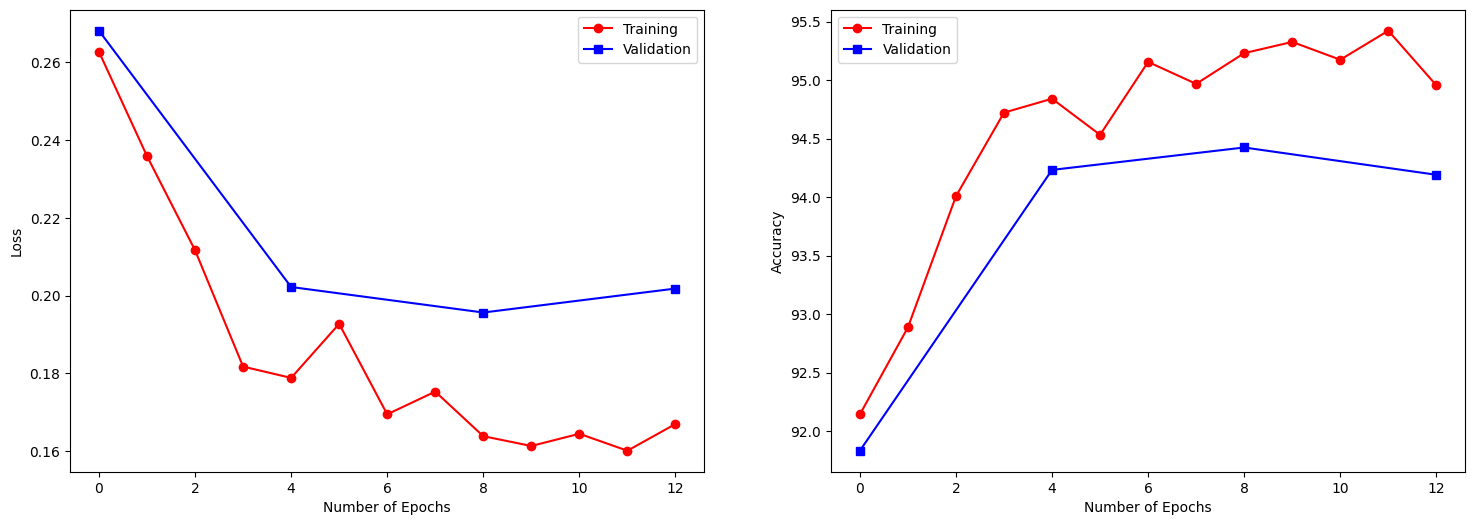

Epoch 13: training loss: 0.15864433739582698, accuracy: 95.17291666666667
Epoch 14: training loss: 0.1583771823743979, accuracy: 95.23333333333333
Epoch 15: training loss: 0.15614863789081573, accuracy: 95.42291666666667
Epoch 16: training loss: 0.1529458103676637, accuracy: 95.60625
Validation loss: 0.1981, validation accuracy: 94.29%


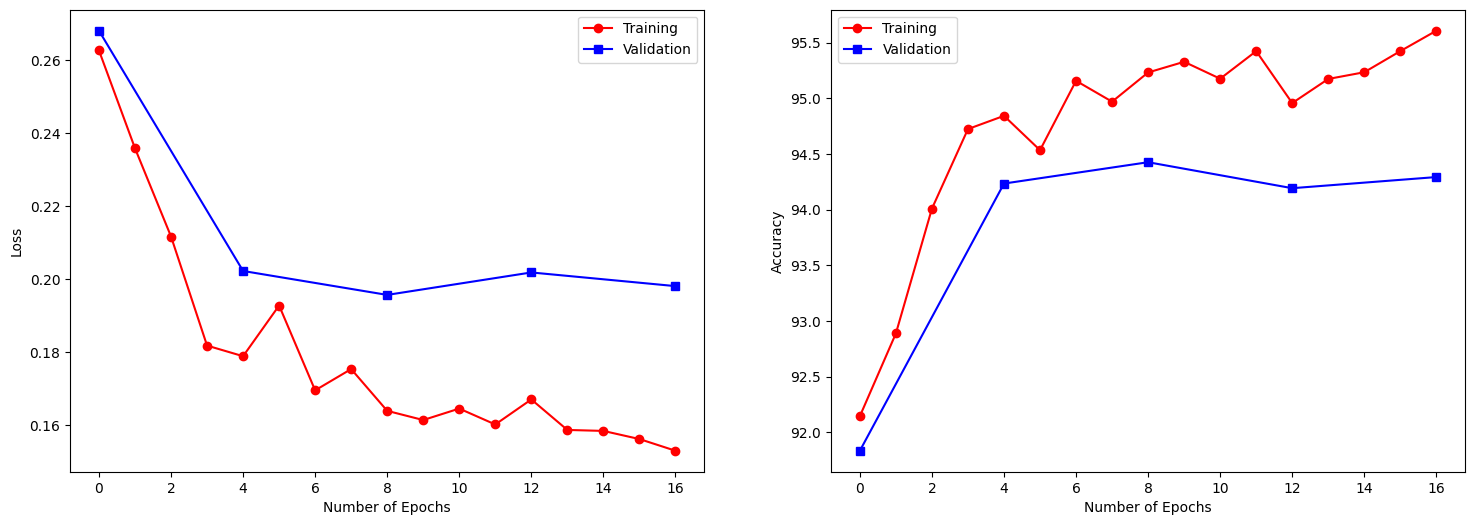

Epoch 17: training loss: 0.1627965741356214, accuracy: 95.0
Epoch 18: training loss: 0.1650032008488973, accuracy: 95.03541666666668
Epoch 19: training loss: 0.15829032595952353, accuracy: 95.2375
Epoch 20: training loss: 0.14579371416568757, accuracy: 95.7
Validation loss: 0.1920, validation accuracy: 94.62%


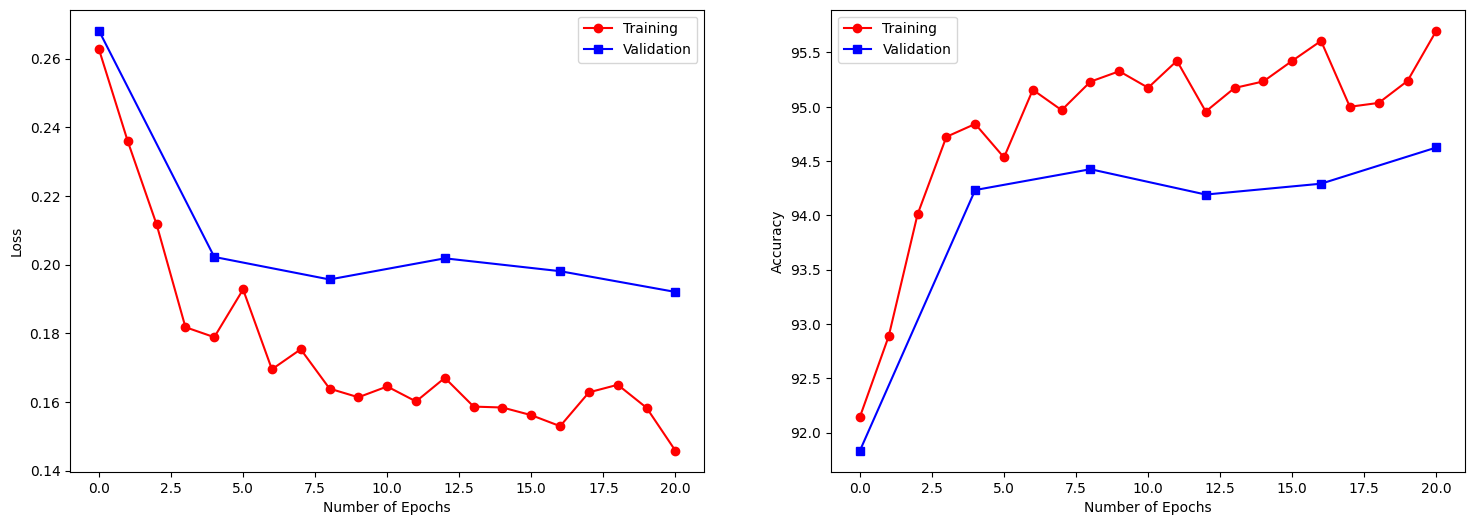

Epoch 21: training loss: 0.17156694661577543, accuracy: 95.05208333333334
Epoch 22: training loss: 0.15020956632494925, accuracy: 95.68333333333334
Epoch 23: training loss: 0.15559294700622558, accuracy: 95.39583333333333
Epoch 24: training loss: 0.14902879393100738, accuracy: 95.6625
Validation loss: 0.1967, validation accuracy: 94.77%


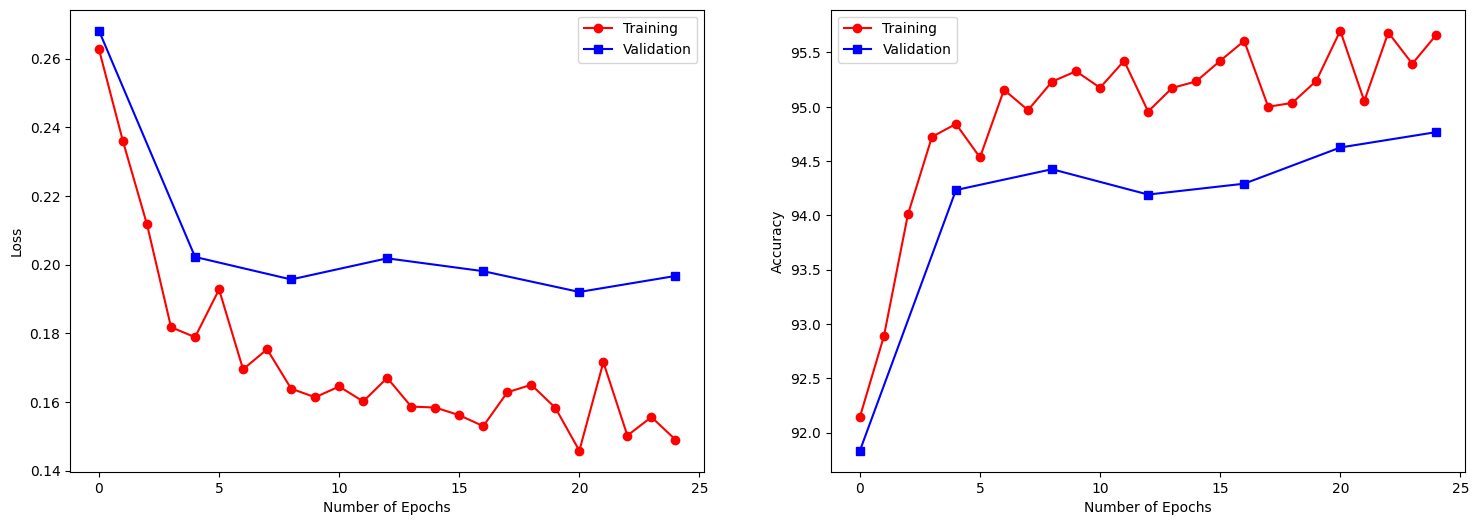

Epoch 25: training loss: 0.148071719566981, accuracy: 95.61041666666667
Epoch 26: training loss: 0.14574087298909824, accuracy: 95.72708333333333
Epoch 27: training loss: 0.15165796401103337, accuracy: 95.39999999999999
Epoch 28: training loss: 0.13960277710358301, accuracy: 95.86458333333333
Validation loss: 0.1853, validation accuracy: 94.97%


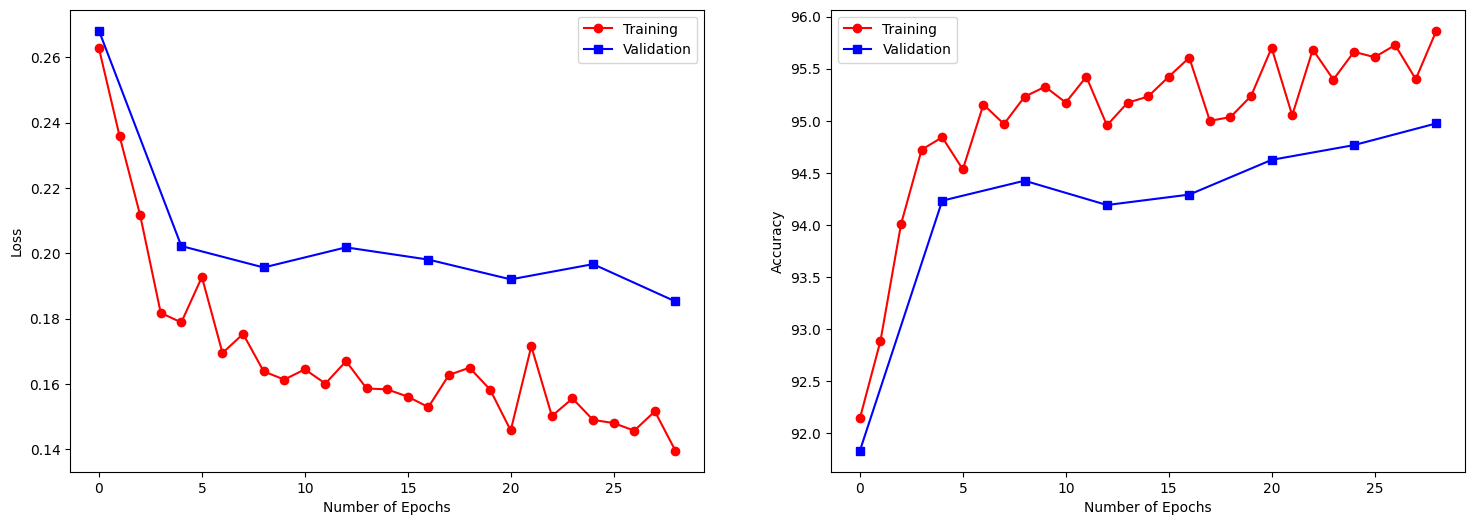

Epoch 29: training loss: 0.14786002258459727, accuracy: 95.69375
Epoch 30: training loss: 0.14792367156843345, accuracy: 95.64375000000001
Epoch 31: training loss: 0.14480694610377154, accuracy: 95.79375
Epoch 32: training loss: 0.1418424503703912, accuracy: 95.75416666666666
Validation loss: 0.1942, validation accuracy: 94.76%


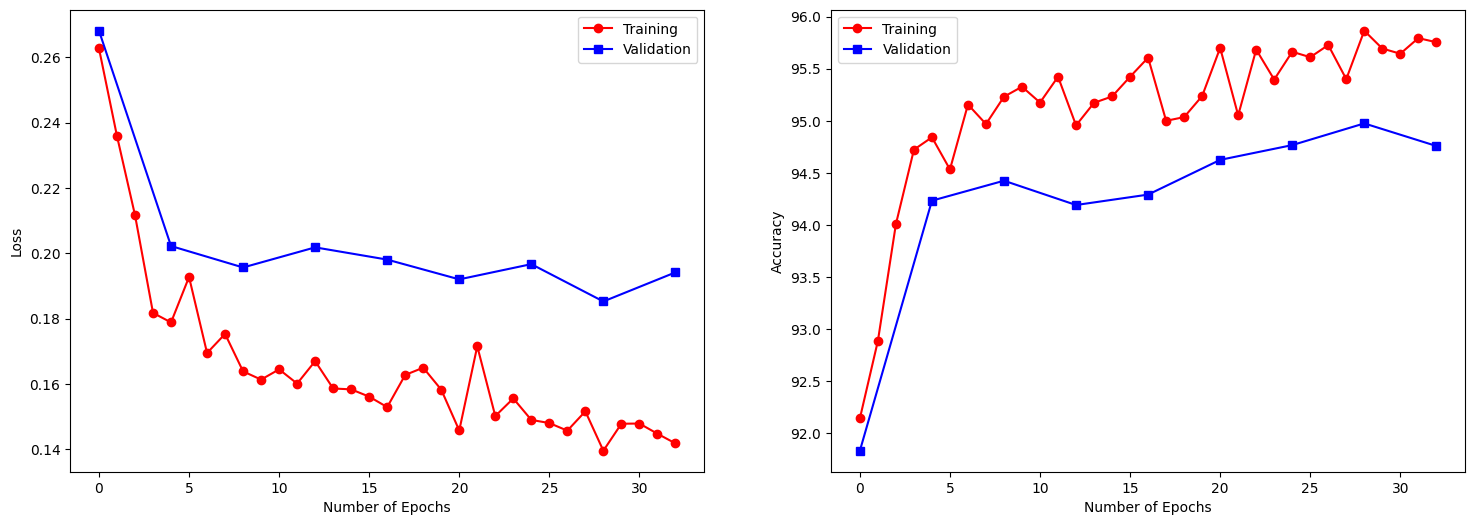

Epoch 33: training loss: 0.15294291253884634, accuracy: 95.55416666666666
Epoch 34: training loss: 0.14111766026417413, accuracy: 95.92708333333333
Epoch 35: training loss: 0.1490092637737592, accuracy: 95.53958333333334
Epoch 36: training loss: 0.14557478405038515, accuracy: 95.78333333333333
Validation loss: 0.2056, validation accuracy: 94.81%


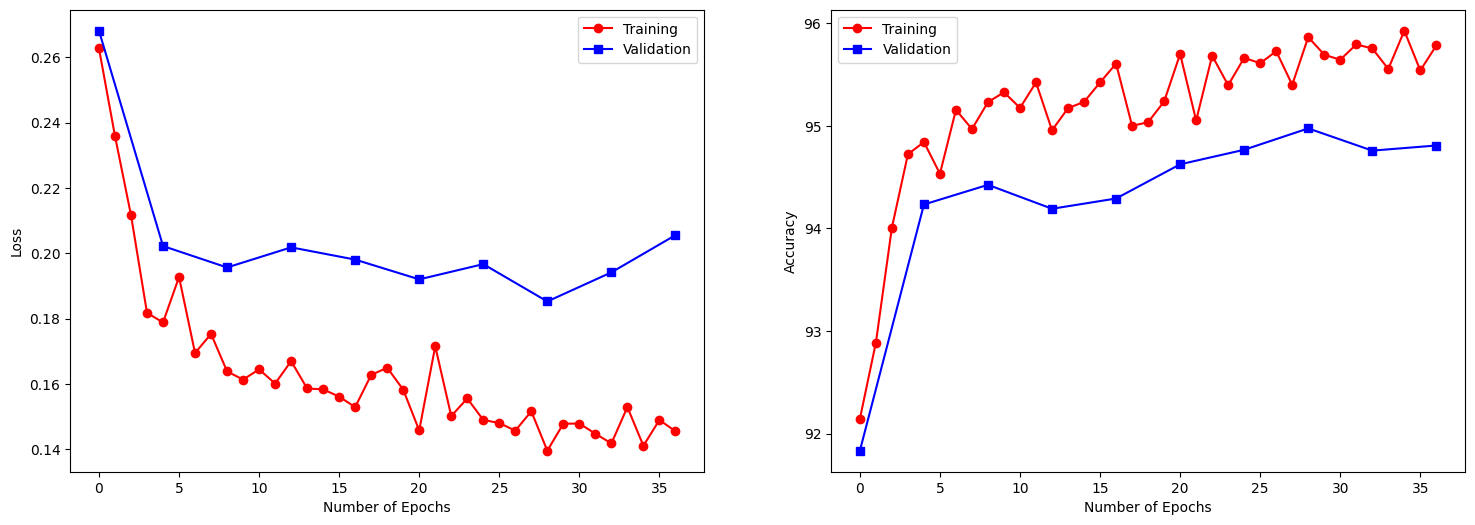

Epoch 37: training loss: 0.1464054848452409, accuracy: 95.60416666666667
Epoch 38: training loss: 0.13834231682618459, accuracy: 95.93333333333334
Epoch 39: training loss: 0.13785602054993312, accuracy: 95.89166666666667
CPU times: user 4min 41s, sys: 3.62 s, total: 4min 44s
Wall time: 4min 42s


In [6]:
%%time

model = MyNonlinearClassifier()
model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_epoch_array = []
train_accuracy_array = []
train_loss_array = []
validation_epoch_array = []
validation_loss_array = []
validation_accuracy_array = []

epochs = 40
n_validations = 10
check_validation = epochs // n_validations
for j in range(epochs):
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    train_epoch_array.append(j)
    train_accuracy_array.append(acc)
    train_loss_array.append(loss)
    
    if j % check_validation == 0:
        # do a validation check
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
        print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))
        validation_epoch_array.append(j)
        validation_loss_array.append(loss_val)
        validation_accuracy_array.append(acc_val)
    
        # update metrics plot
        fig, axes = plt.subplots(1, 2, figsize=(18,6), dpi=100)

        axes[0].plot(train_epoch_array, train_loss_array, 'or-', label='Training')
        axes[0].plot(validation_epoch_array, validation_loss_array, 'sb-', label='Validation')
        axes[0].set_xlabel('Number of Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        axes[1].plot(train_epoch_array, train_accuracy_array, 'or-', label='Training')
        axes[1].plot(validation_epoch_array, validation_accuracy_array, 'sb-', label='Validation')
        axes[1].set_xlabel('Number of Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()

        plt.show()

As the plots indicate, the model continues to drive the loss down (i.e., drive the accuracy up) for the majority of the epochs. But, as we validate with data the model hasn't seen, we reach a point where the model is less accurate with the new, unseen data. This appears to be around 20 epochs. So, for the purposes of this data and this model, about 20 epochs seems to be the optimal number of passes over the data.

Let's retrian and test our model:

### Model Re-Training and Testing

In [9]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:].cpu(), cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Epoch 0: training loss: 0.24287629493077595, accuracy: 92.99374999999999
Epoch 1: training loss: 0.21373467073837915, accuracy: 93.8
Epoch 2: training loss: 0.20428114028771718, accuracy: 94.32708333333333
Epoch 3: training loss: 0.19199914117654165, accuracy: 94.35416666666666
Epoch 4: training loss: 0.18185834087928135, accuracy: 94.82291666666667
Epoch 5: training loss: 0.17021566050251324, accuracy: 95.0
Epoch 6: training loss: 0.16554230625430744, accuracy: 95.13958333333333
Epoch 7: training loss: 0.17476354001959166, accuracy: 94.77499999999999
Epoch 8: training loss: 0.17485570535063744, accuracy: 94.80833333333332
Epoch 9: training loss: 0.167140849173069, accuracy: 95.09791666666668
Epoch 10: training loss: 0.1520309819082419, accuracy: 95.75625
Epoch 11: training loss: 0.15914558374881743, accuracy: 95.36666666666666
Epoch 12: training loss: 0.15868511801958085, accuracy: 95.35625
Epoch 13: training loss: 0.16816535701354346, accuracy: 95.00833333333333
Epoch 14: training lo

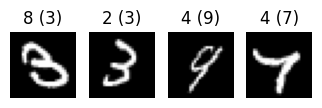

In [10]:
%%time

model = MyNonlinearClassifier()
model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_epoch_array = []
train_accuracy_array = []
train_loss_array = []

epochs = 20
for j in range(epochs):
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
# evaluate the model with test data
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_test, acc_test))

# show model failures
show_failures(model, test_dataloader)

As indicated above, our non-linear model gets an accuracy of about 94.9%.